# ロジスティック回帰 

回帰って書いてあるけど厳密には分類  
・線形分類  
・2値分類  
とかに使われる

### シグモイド関数のプロット

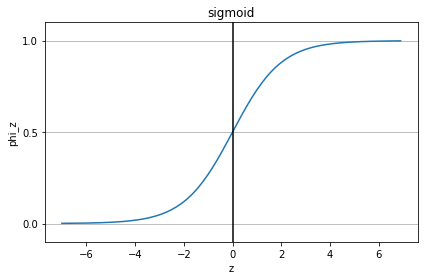

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sigmoid
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
# phi_z

plt.plot(z, phi_z)
# 垂直線を追加しておく
plt.axvline(0.0, color='k')
# y軸の上限と下限
plt.ylim(-0.1, 1.1)
# 軸ラベル
plt.xlabel('z')
plt.ylabel('phi_z')
# y軸の目盛り
plt.yticks([0.0, 0.5, 1.0])

# axeクラスのオブジェクトを取得
ax = plt.gca()
# y軸の目盛りに合わせて水平グリッド線を追加
ax.yaxis.grid(True)

#グラフ表示
plt.title('sigmoid')
plt.tight_layout()
plt.show()


### 総入力を活性化関数に通したあとの出力$φ(z)$ のいろんな値に対する誤差（2値交差エントロピー）を見てみる

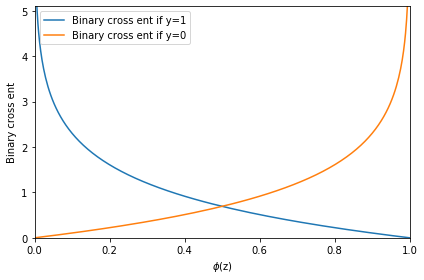

In [4]:
# 目標値yが1の時の目的関数
def cost_1(z):
    return -np.log(sigmoid(z))

# 目標値yが0の時の目的関数
def cost_0(z):
    return -np.log(1-sigmoid(z))

# 適当なデータを作る
z = np.arange(-10, 10, 0.1)

# シグモイド関数に入力を与える
phi_z = sigmoid(z)

# y=1の時の結果をリストに格納
cost1 = [cost_1(x) for x in z]
plt.plot(phi_z, cost1, label='Binary cross ent if y=1')

# y=0の時の結果をリストに格納
cost0 = [cost_0(x) for x in z]
plt.plot(phi_z, cost0, label='Binary cross ent if y=0')

# グラフを整える
plt.xlim([0,1])
plt.ylim(0.0, 5.1)
plt.xlabel('$\phi$(z)')
plt.ylabel('Binary cross ent')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### ADALINE(バッチ処理)で実装したアルゴリズムをロジスティック回帰のアルゴリズムに変換してみる

具体的には以下3点を変更する  
  

・目的関数を  
二乗誤差　→ 2値交差エントロピー  
に置き換える  
  
・活性化関数を  
恒等関数　→ シグモイド関数  
に置き換える  
  
・しきい値関数を[0,1]のクラスラベルを返すように変える

In [7]:
import numpy as np

class LogsticRegressionGD(object):
    """
    param:
    eta: float, 学習率
    n_iter: int, トレーニング回数
    random_state: int, 重みを初期化する乱数シード
    
    attribute:
    w_: 1次元配列, 学習した重み
    cost_: list, 予測値と目標値を使って計算された誤差
    
    """
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """
        param:
        X: 訓練データ
        y: 予測値
        
        戻り値:
        self: オブジェクト
        
        """
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        # n_iter分モデルを学習（訓練）させる
        for i in range(self.n_iter):
            # 計算した総入力を代入
            net_input = self.net_input(X)
            
            # 活性化関数に代入
            output = self.activation(net_input)
            
            # 誤差を計算
            errors = (y - output)
            
            # 重みの更新（w_1 ~ w_n）
            self.w_[1:] += self.eta * X.T.dot(errors)
            
            # w_0の更新
            self.w_[0] += self.eta * errors.sum()
            
            # コスト関数(Binary cross ent)の計算
            cost = -y.dot(np.log(output)) - ((1-y).dot(np.log(1-output)))
            self.cost_.append(cost)
        return self
    
    
    def net_input(self, X):
        # 総入力を計算
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    
    def activation(self, z):
        # ロジスティックシグモイド関数
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))
    
    
    def predict(self, X):
        # 1ステップ後のクラスラベルを返す
        return np.where(self.net_input(X) >= 0.0, 1, 0)       

↑のLogisthicRegressionは2値分類タスクに対してのみうまく適合できる  
→Irisデータセットの品種クラスを、SetosaとVersicolorのみで試してみる

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


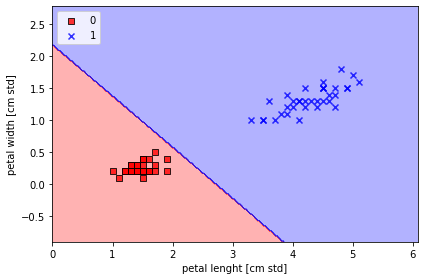

In [9]:
from plot_decision_regions import plot_decision_regions as pdr
import pandas as pd
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
# y = df.iloc[0:100, 4].values
# y = np.where(y == 'Iris-setosa', 0, 1)
# X = df.iloc[0:100, [0, 2]].values

iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

# データセットの分割（訓練、テスト）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

# インスタンス生成
lrgd = LogsticRegressionGD(eta=0.5, n_iter=1000, random_state=1)
# モデルの学習
lrgd.fit(X_train_01_subset, y_train_01_subset)
# 決定領域のプロット
pdr(X=X_train_01_subset, y=y_train_01_subset, classifier=lrgd)

# グラフの設定
plt.xlabel('petal lenght [cm std]')
plt.ylabel('petal width [cm std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 以下、sklearnを使ったロジスティック回帰で分類してみる

sklearnが標準で持っているロジスティック回帰モデルは、デフォルトで多クラス分類に対応している

In [10]:
# 特徴量のスケーリング
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# 訓練データの平均と標準偏差を取得
sc.fit(X_train)

# スケーリング、今回は標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

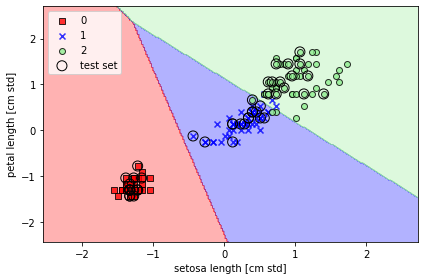

In [15]:
# 訓練データとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))

# 訓練データとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train, y_test))

# 決定境界のプロット
pdr(X=X_combined_std, y=y_combined, classifier=lr, test_idx=range(105,150))

plt.xlabel('setosa length [cm std]')
plt.ylabel('petal length [cm std]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### サンプルがある特定のクラスに属する確率を考えてみる

In [17]:
X_test_std[:3]

array([[ 0.89820289,  1.44587881],
       [-1.16537974, -1.04507821],
       [-1.33269725, -1.17618121]])

In [19]:
lr.predict_proba(X_test_std[:3])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

In [24]:
lr.predict_proba(X_test_std[:3]).sum(axis=1)

array([1., 1., 1.])

In [25]:
lr.predict_proba(X_test_std[:3]).argmax(axis=1)

array([2, 0, 0])

この結果が正しいことを比較するために・・・

In [26]:
lr.predict_proba(X_test_std[0])

ValueError: Expected 2D array, got 1D array instead:
array=[0.89820289 1.44587881].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [29]:
X_test_std[0]

array([0.89820289, 1.44587881])

In [27]:
X_test_std[0].shape

(2,)

In [28]:
X_test_std[0].reshape(1,2)

array([[0.89820289, 1.44587881]])

In [35]:
lr.predict_proba(X_test_std[0].reshape(1,2))

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01]])

In [36]:
lr.predict_proba(X_test_std[0].reshape(1,2)).argmax(axis=1)

array([2])